#  0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import math
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
import datetime

from IPython.core.display import HTML
from IPython.display import Image


## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)

# merge 

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
747307,1043,6,2013-08-31,8513,1338,1,0,0,0,c,a,420.0,3.0,2006.0,0,NaN,NaN,NaN


#  1.0 Descrição dos Dados (Limpeza)

## 1.1. Rename Columns

In [4]:
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Deixar minusculo com underline
snakecase = lambda x: inflection.underscore( x )

# Passando Snakecase em todas as palavras de cols_old que é onde queremos aplicar
cols_new = list( map( snakecase, cols_old ) )

# Rename
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA's

In [9]:
# Contando NA's por coluna

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Preencher NA's 

In [10]:
# Formas de Tratar NA's
# 1. Excluir Linhas - Mas perdermos muitos dados
# 2. Fazer como se fosse uma "média" dos valores para preencher
# 3. Tentar enteder o negócio, do porque aqueles dados estão NA

# Vamos fazer a 3!
# Para isso, lemos no kaggle o que cada coluna é e faz

In [11]:
# Verificação de colunas que contém NA's (durante e após o tratamento)

# competition_distance
# Vendo o valor máximo da coluna, lá na frente colocaremos uma valor muito maior para substituir os NA's
print(df1['competition_distance'].max())
print(df1['competition_distance'].isna().sum())

print(df1['competition_open_since_month'].isna().sum())

75860.0
2642
323348


In [12]:
# competition_open_since_month  
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
434833,769,6,2014-06-07,12001,3746,1,0,0,0,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct"


In [13]:
# Tratamento:

# competition_distance   
# Colocaremos um valor muito mais alto do que o máximo encontrado de 75860
# Aplique em cada linha da coluna competition_distance a lógica if. Se for vazio, coloque 200.000
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month (quanto tempo faz que tenho uma competição aberta)
# Essa coluna é boa manter devido a ser uma boa feature enginering, e porque vamos manter essa coluna? 
# Se não tenho um competidor (concorrente) perto minhas vendas são mais altas, agr se eu tenho, tendem a abaixar
# E quando uma loja abre, ela tende a puxar pessoas. Mas depois de um tempo, as pessoas acostumam com as duas
# lojas e as duas voltama  vender. isso explica bem baixas e altas de vendas.
# Parece fazer sentido, porém, depois que rodarmos o algoritimo vamos saber de fato se essa coluna 
# influncia demais ou não

# axis=1 é que é para aplicar em todas as colunas, pois usamos a coluna date para fazer uma lógica na coluna competition_open_since_month
# Quando estiver vazio, colocaremos a o mês da coluna data daquela linha
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

# competition_open_since_year   
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)
                      
# promo2_since_week       
# Extraindo a semana da data
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

# promo2_since_year  
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)



In [14]:
# promo_interval             
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

# Se for NA, trocar por zero, inplace é para modificar direto na coluna sem retornar valor
df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

# Fazemos essa lógica para saber se o month_map (descritivos do mês) está dentro da promoção ou não, se sim retorna 1
df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [15]:
df1.sample(5).T

,266476,950848,505398,801254,804359
store,220,539,1089,355,115
day_of_week,6,5,6,6,3
date,2014-11-29 00:00:00,2013-03-01 00:00:00,2014-04-05 00:00:00,2013-07-13 00:00:00,2013-07-10 00:00:00
sales,4867,10388,9957,5862,5410
customers,591,1115,1067,721,458
open,1,1,1,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,d,a,d


In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types (após tratar dados, o resultado pode alterar o tipo)

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
# alterar de float para int

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descrição Estatística

In [20]:
# Métricas estatísticas de primeira ordem:
# métricas de Tendência Central - Resumem tudo em um único número (ex.: Média / Mediana)
# medidas de dispersão - Ver com os dados estão dispersos (min, max, std, range, skew, kurtosis, etc)

In [21]:
num_attributes = df1.select_dtypes( include=['int64','float64'] )
cat_atributes = df1.select_dtypes( exclude=['int64','float64', 'datetime64[ns]'] )

In [22]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
787121,717,5,3523,433,1,0,1,310.0,7,2013,1,40,2011,1
860349,355,2,8314,1107,1,0,0,9720.0,8,2013,0,21,2013,0


In [23]:
cat_atributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
521904,0,a,a,0,Mar
513584,0,a,c,0,Mar


## 1.7.1. Numerical Atributes

In [24]:
# Central Tendency - mean, median

# O apply foi usado para aplicar a média e a mediana em todas as colunas
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# Concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis'] 

In [25]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


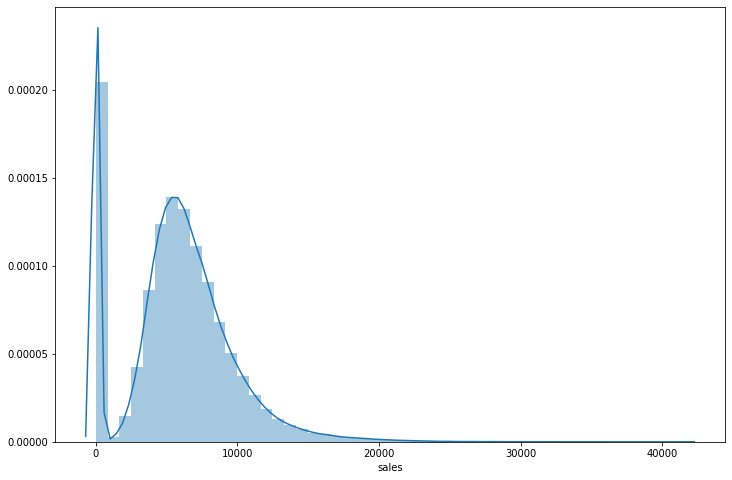

In [26]:
# Vendo a "normal"

ax = sns.distplot( df1['sales'] )
ax.figure.set_size_inches(12,8)

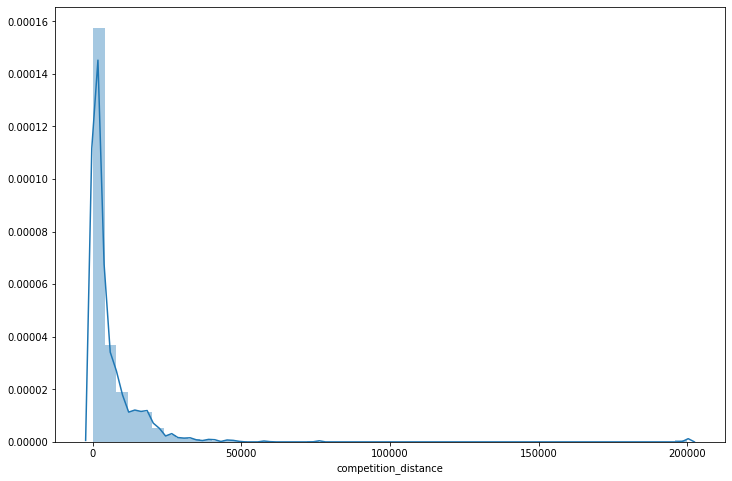

In [27]:
# Vendo a "normal"
# Kurtosis e skew muito alta
# O pico fica perto do zero

ax = sns.distplot( df1['competition_distance'] )
ax.figure.set_size_inches(12,8)

## 1.7.2. Categorical Attributes

In [28]:
# Pegando a quantidade única de tipos de atributos
cat_atributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

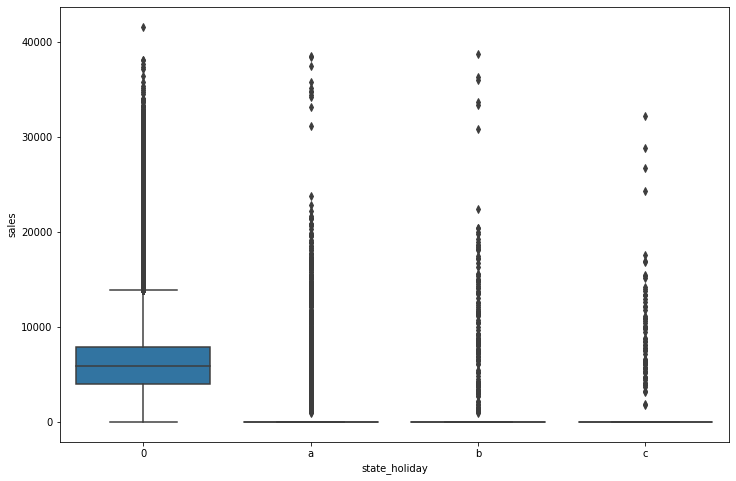

In [29]:
# Não da pra enxergar nada, entã precisams filtrar
# Boxplot, é bom para ver dados categoricos

ax = sns.boxplot( x='state_holiday' , y='sales' , data=df1 )
ax.figure.set_size_inches(12,8)

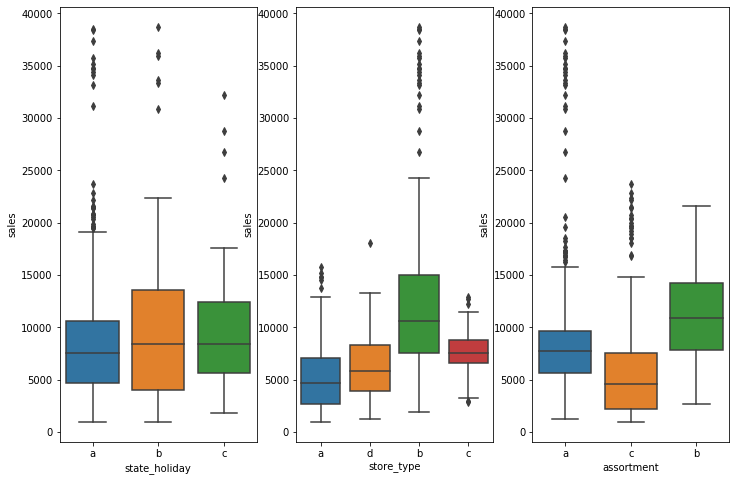

In [30]:
# Aqui vamos tirar todo acumulado de dias que não tiveram vendas pq a loja tava fechada

aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
ax = sns.boxplot( x='state_holiday' , y='sales' , data=aux1 )
ax.figure.set_size_inches(12,8)

plt.subplot(1, 3, 2)
ax1 = sns.boxplot( x='store_type' , y='sales' , data=aux1 )
ax1.figure.set_size_inches(12,8)

plt.subplot(1, 3, 3)
ax2 = sns.boxplot( x='assortment' , y='sales' , data=aux1 )
ax2.figure.set_size_inches(12,8)


# 2.0 Feature Engineering 

## 2.1. Mapa Mental de Hipóteses

In [31]:
# A partir daqui entramos na etapa de exploração de dados que possui basicamente 3 tarefas


# 1 Criar e derivar as variáves
# 2 Criar uma lista de hipóteses
# 3 Validar essas hipóteses


In [32]:
# É preciso ter variáveis DISPONÍVEIS para ESTUDO durante a Análise Exploratória de Dados

In [33]:
# Fazer Mapa Mensal de Hipóteses

# Fenômeno: Qual fenômeno estou modelando?
# Agentes: Quem são os agentes que atuam sobre o fenômeno de interesse?
# Atributos dos Agentes: Qual a descrição dos agentes? (idade, nome, altura, salário, estado civil, qtd filhos)
# Lista de Hipóteses

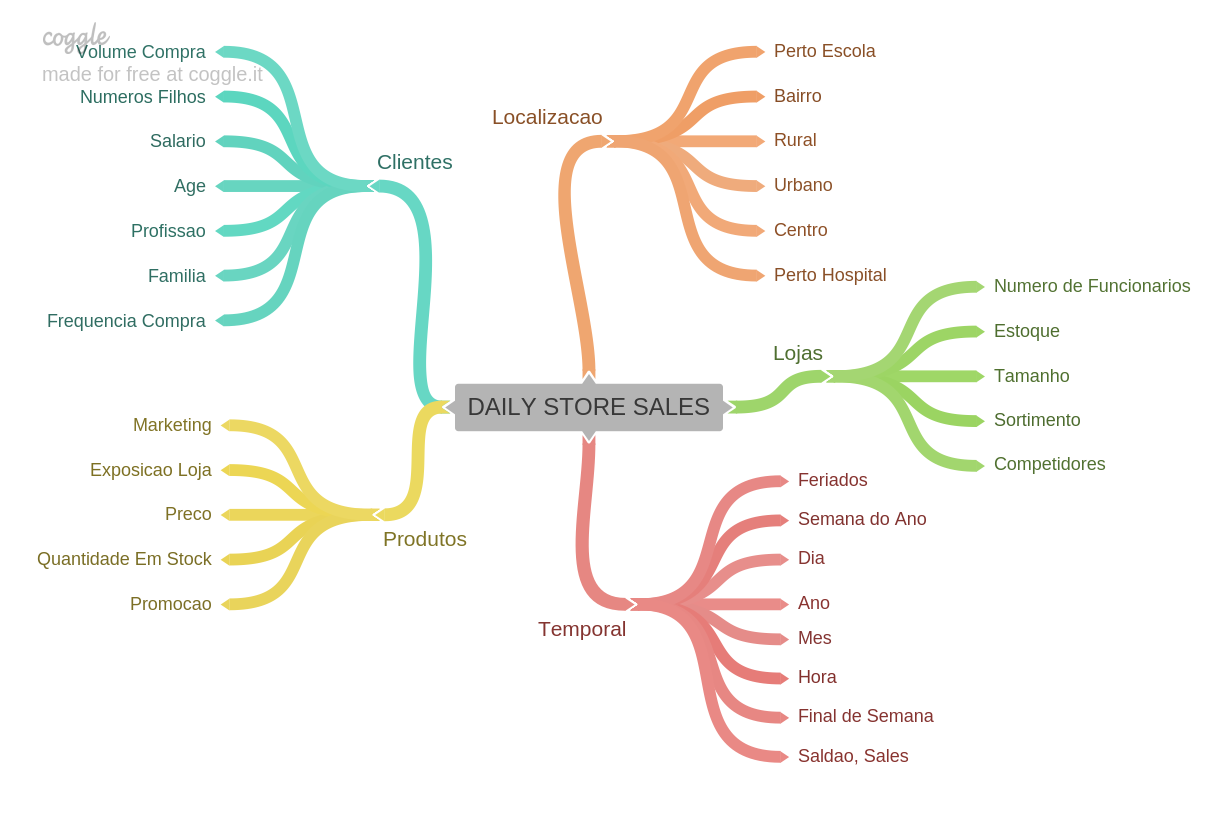

In [34]:
Image('img/MindMapHypothesis.png')

## 2.2. Criação das Hipóteses

In [35]:
# Como escrever as Hipóteses? 

# Hipóteses são Apostas! 
# Lojas de MAIOR porte .... deveriam vender MAIS.

# A hipótese nos guia para as apostas. 
# a hipótese não é causa e efeito, é simplismente um correlação
# Não podemos afirmar que lojas maiores vendem mais, porque vendas sofrem impactos de muitas variáveis 
# e não só apenas se as lojas são maiores ou não. 

# Lojas com MAIOR sortimento ... deveriam vender MAIS
# Lojsa com MAIS concorrentes perto ... deveriam vender MENOS


### 2.2.1. Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais. 

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

Hipoteses que vamos trabalhar

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem prelos menores por mais tempo nos produtos deveriam vender mais. 

Hipoteses que vamos trabalhar

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
4. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
5. Lojas com promoções ativas por mais tempo deveriam vender mais.
6. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3. Hipóteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.


Hipoteses que vamos trabalhar

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses (que são possíveis analisar com nossos dados)

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

In [36]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.4. Feature Engineering

In [37]:
df2 = df1.copy()

# Derivadas da coluna date

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )



# Derivadas de Tempo de competição e promoção

# competition since

# colocamos day = 1 para considerar o mês como um todo
# datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 )
# axis = 1 pois estamos usando 2 colunas

df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )

# Tentativas de correção
#df2['date'] = pd.to_datetime(df2['date'])
#df2['competition_since'] = pd.to_datetime( df2['competition_since'])
# df2['competition_since'] = df2['competition_since'].dt.strftime('%Y-%m-%d')


In [38]:

# Fazemos uma data menos a outra para ter a diferença de dias entre elas 
# Depois dividimos por 30 para manter a granularidade mínima do mês
# O método days extrai os dias do datetime, nos permitindo converter para inteiro
# Tempo em meses
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x:x.days).astype(int)


In [39]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [40]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [41]:

# Coluna: promo since

# vamos fazer primeiro um join de strings e depois vamos converter em uma data (para juntar tem que ser str)
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

# Truque para converter para data
# Não precisamos colocar o axis=1 porque é apenas uma coluna
# Vamos sobrescrever o valor string para data na propria coluna
# w minúsculo é o número da semana de domingo a domingo
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ))

# Vamos criar a coluna que mostra o tempo que a promoção está ativa em semanas
# Agora vamos tirar a diferença entre as datas. 
# Dividimos por 7 para ter em semanas
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)


# Coluna: assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )


# Coluna: state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day')


In [42]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular day,regular day,regular day,regular day,regular day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [43]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0. Filtragem de Variáveis

In [ ]:

# Variáveis x Seleção de Variáveis

# É preciso filtrar as restrições do negócio (como por exemplo, dados que o négocio não pode fornecer pra gente)

# Não da pra esperar temos um algoritimo treinado pra rodar em produção, ai quando vamos conversar com o negócio, 
# eles nos dizerem que não conseguem nos fornecer um dado específico que o algoritimo vai precisar. 

# Esse papel é do cientista! 


In [44]:
df3 = df2.copy()

In [45]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [ ]:

# Loja fechada não faz sentido termos essas linhas
# 'open' != 0
# Vendas precisam ser maior que zero. Outras linhas que não fazem sentido
# 'sales' > 0



In [50]:
df2.shape

(1017209, 29)

In [46]:
# Tirando linhas indesejadas

df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]


In [51]:
df3.shape

(844338, 25)

## 3.2. Seleção das Colunas

In [ ]:

# Exemplo, a coluna "customers" nós não temos no momento da predição
# Quantidade de clientes só tem como saber depois que acontece
# Não temos essa variável disponível no momento da predição
# Só teria como termos se criassemos uma predição dela isoladamente e colocássemos nesse projeto, mas não vamos fazer isso
# Ela é uma restrição de negócio


In [47]:
# Aqui dropamos colunas que não fazem sentido ou colunas que usamos para derivar variáveis
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

# axis=1 porque são colunas
df3 = df3.drop( cols_drop, axis=1 )

In [52]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Análise Exploratória de Dados


Serve para medir o impacto das variáveis em relação a variável resposta e tentar quantificar esse impacto.

Os 3 objetivos da EDA:

1) Ganhar Experiência de Negócio.

2) Validar Hipóteses de Negócio (Chocar as crenças do Negócio - Gerar novos insights)

3) Perceber Variáveis que são importantes para o Modelo.

*A análise exploratória de dados é constituida por 3 tipos de analises:* 

1) Análise Univariada - Como é essa variável (min, max, distribuição, Range, etc)? 

2) Análise Bivariada - Como a variável impacta a resposta? (correlação, validação de hipóteses)

3) Análise Multivariada - Como as variáveis se relacionam?

## 4.1. Análise Univariada

### 4.1.1. Response Variable (Variável Resposta)

In [56]:
df4 = df3.copy()
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular day,regular day,regular day,regular day,regular day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270,570,14130,620,29910


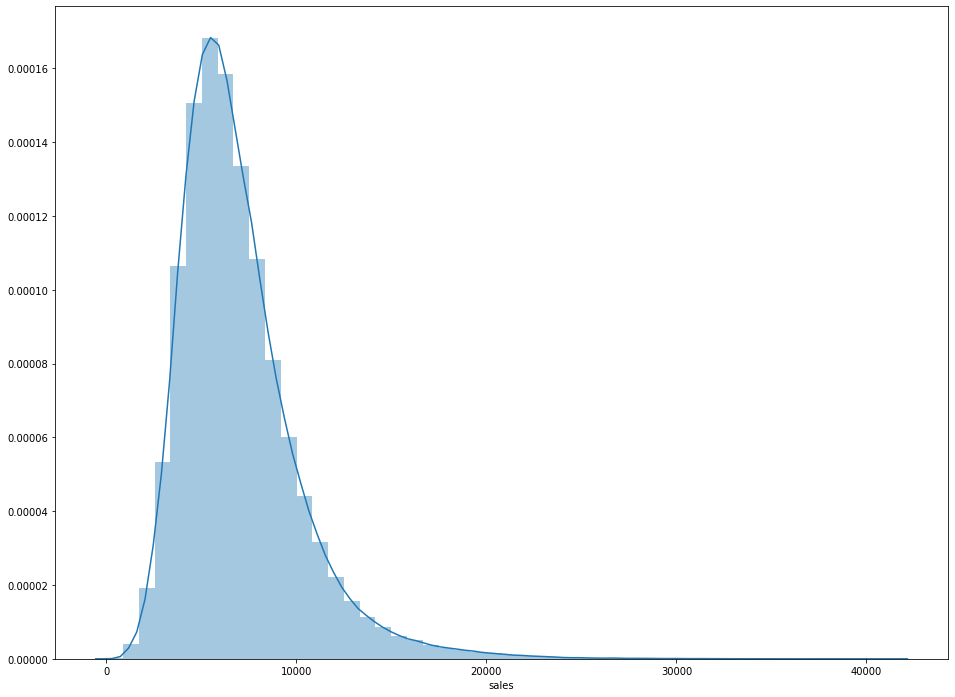

In [69]:
# Pegamos Sales porque é a variável resposta, ou seja, todo foco é analisar vendas
# Ela tem um formato de um sino, tem uma kurtosis, uma skill mais pra esquerda mais não está centrada(n tem problema)
# Próxima com uma normal, mas não é uma normal.
# Nos importamos por isso porque os algoritimos de machine learning são criados com algumas premissas
# Uma dessas condições é que os dados sejam independentes e distribuidos, sigam uma distribuição normal
# Quanto mais normal sua variável resposta, melhor seu algoritimo vai performar
# Existem varias tecnicas de trasnformações para transformar elas o mais próximas possíveis de uma normal.

# usamos o kde-False, para plotar só o histograma sem a linha, ai os valores ficam maiores
# ax = sns.distplot( df4['sales'], kde=False)

ax = sns.distplot( df4['sales'])
ax.figure.set_size_inches(16,12)

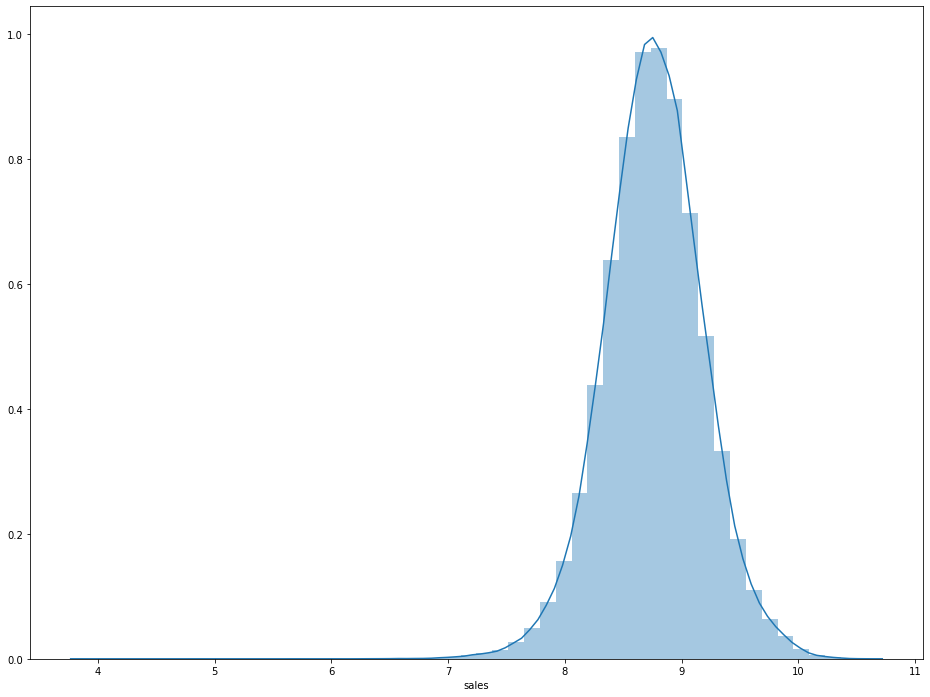

In [65]:
# Veja abaixo um exemplo de trsanformação de normal que é multiplicar todos os valores de vendas pelo log
# Tecnica muito usada de transformação
# Aqui está mais próxima de uma normal
# Mas utilizaremos a nossa sem nenhuma técnica (gráfico anterior)

ax = sns.distplot( np.log1p( df4['sales'] )) 
ax.figure.set_size_inches(16,12)

### 4.1.2. Numerical Variable

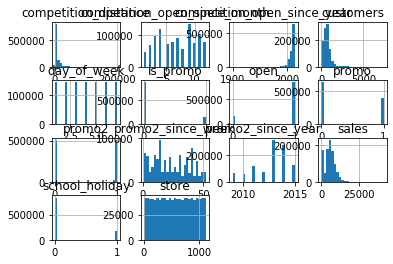

In [87]:
num_attributes.hist(bins=25);

<ipython-input-89-a93e333d923b>:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_attributes.hist(ax=ax)


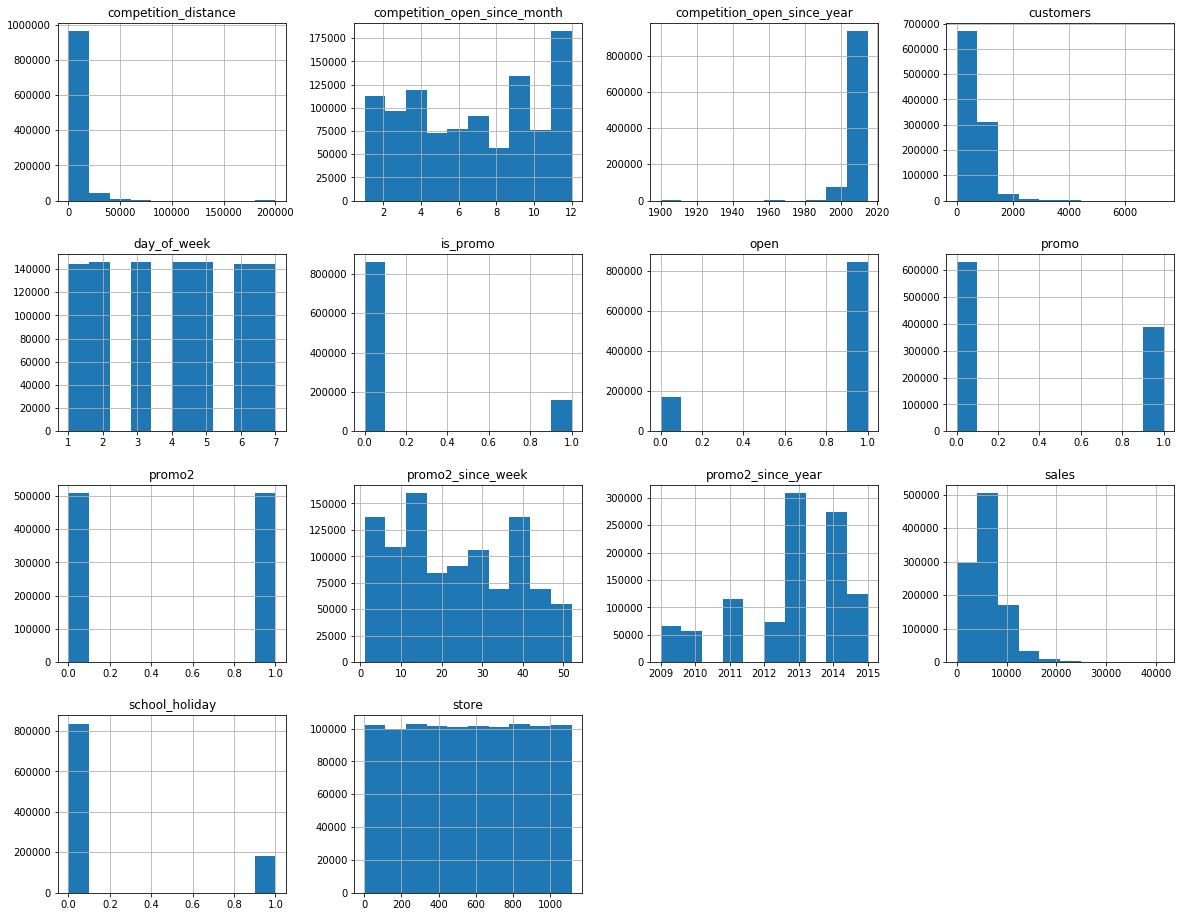

In [89]:
#Gerando o histograma dasvariáveis numéricas

import matplotlib.pyplot as plt

# Crie uma figura e um eixo
fig, ax = plt.subplots(figsize=(20, 16))

# Gere o histograma no eixo
num_attributes.hist(ax=ax)

# Mostre o histograma
plt.show()

# Competition_distance - Existe uma concetração maior em competições menores,
# Isso representa que todos os competidores estão muito próximos

# Competition_open_since_month - Da pra analisar um comportamento (mais explicativa de um fenomeno) 

# Já day_of_week quase não tem variação, então não importa o dia da semana, vende quase sempre a mesma coisa em
# qualquer dia, o que representa que ela sozinha por exemplo, não tem relevancia nenhuma

# São informações assim que procuramos observar

# Ispromo - Temos muito mais vendas quanto eu não tenho promoção (0) do que quanto tenho promoção
# É estranho, mas pode ser um insight

# No promo 2, por ano, podemos entender com o negócio porque teve um pico em 2013 por exemplo.

### 4.1.3. Categorical Variable

In [91]:
cat_atributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [92]:
# Tipos Únicos de feriados
df4['state_holiday'].drop_duplicates()

0            regular day
63559     public holiday
129424    easter holiday
241126         christmas
Name: state_holiday, dtype: object

In [112]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [122]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

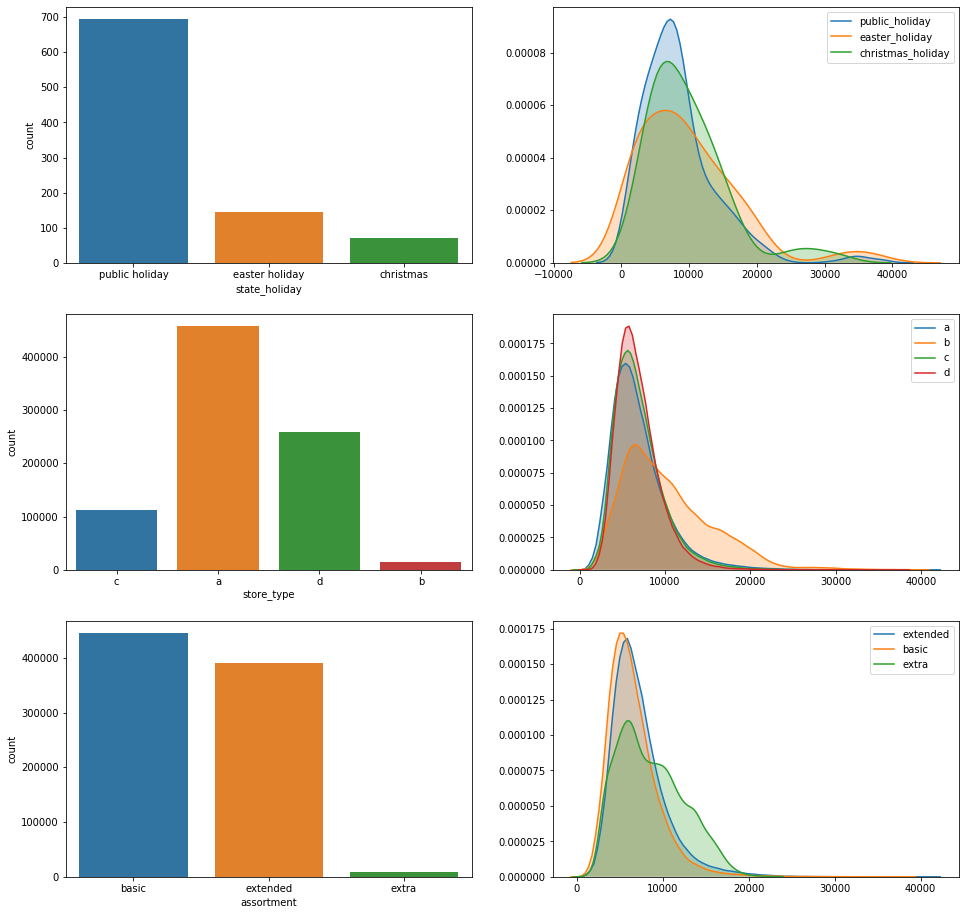

In [125]:

# state_holiday
# tiramos o regular day por ele ser muito maior que as outras
# temos um volume maior em feriados públicos, depois na páscoa e depois no Natal

plt.subplot(3, 2, 1)
a = df4[ df4['state_holiday'] != 'regular day' ]
ax = sns.countplot( a['state_holiday'] )
ax.figure.set_size_inches(16,16)

# No exemplo abaixo, vemos por exemplo que o Natal tem menos vendas, porém tem um pico muito maior
# Essa variável provalvelmente vai ser importante para o aprendizado do modelo

plt.subplot(3, 2, 2)
sns.kdeplot( df4[ df4['state_holiday'] == 'public holiday' ]['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'easter holiday' ]['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'christmas' ]['sales'], label='christmas_holiday', shade=True )
#figure.set_size_inches(16,8)


# store_type
plt.subplot(3, 2, 3)
ax = sns.countplot( df4['store_type'] )
#ax.figure.set_size_inches(16,8)


plt.subplot(3, 2, 4)
sns.kdeplot( df4[ df4['store_type'] == 'a' ]['sales'], label='a', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'b' ]['sales'], label='b', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'c' ]['sales'], label='c', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'd' ]['sales'], label='d', shade=True )
#figure.set_size_inches(16,8)

# assortment
plt.subplot(3, 2, 5)
ax = sns.countplot( df4['assortment'] )
#ax.figure.set_size_inches(16,8)


plt.subplot(3, 2, 6)
sns.kdeplot( df4[ df4['assortment'] == 'extended' ]['sales'], label='extended', shade=True )
sns.kdeplot( df4[ df4['assortment'] == 'basic' ]['sales'], label='basic', shade=True )
sns.kdeplot( df4[ df4['assortment'] == 'extra' ]['sales'], label='extra', shade=True )
#figure.set_size_inches(16,8)



## 4.2. Análise Bivariada

## 4.3. Análise Multivariada